In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
from sympy import Symbol
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import sys
sys.path.append("../../..")
from utils.plot_utils import set_fontsize

In [2]:
nprocs = 6

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,2]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [1/2]
excited_Fs= [1]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 2


# main laser transitio n R(0) F'=1 F1'=1/2

ground_main_approx = 1*centrex.CoupledBasisState(J=0,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2,electronic_state='X', 
                                         P = (-1)**0, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,
                                          F1=1/2,
                                          F=1,
                                          mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [0]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "laser transition"
               }]

In [3]:
# specify states to combine into a single level 
# e.g. only decay to these states and not interested in population distribution there
slice_compact = np.s_[4:24]

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [4]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωp', 'ϕp', 'y0', 'vy', 'vz', 'μzlaser', 'σylaser', 'σzlaser', 'β', 'ωphase']

In [5]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tδl = p[2]
\t\tωp = p[3]
\t\tϕp = p[4]
\t\ty0 = p[5]
\t\tvy = p[6]
\t\tvz = p[7]
\t\tμzlaser = p[8]
\t\tσylaser = p[9]
\t\tσzlaser = p[10]
\t\tβ = p[11]
\t\tωphase = p[12]
\t\tΩl = Ωl .* gaussian_2d(vz*t, y0+vy*t, 1., μzlaser, 0., σzlaser, σylaser) .* phase_modulation(t, β, ωphase)

\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωp*t + ϕp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2
"""

In [7]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωp = Γ
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωp: 9.80e+06, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 0.00e+00, μzlaser: 0.00e+00, σylaser: 0.00e+00, σzlaser: 0.00e+00, β: 0.00e+00, ωphase: 0.00e+00)

## Start calculations for Hamiltonian and transitions

In [8]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 6.67 s


In [9]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs)
    couplings.append(coupling)

Wall time: 2.59 s


In [10]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 135 ms


In [11]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 500 ms


In [12]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs)

Wall time: 4.52 s


In [13]:
QNcompact = [QN[idx] for idx in range(len(QN)) if idx not in range(slice_compact.start+1, slice_compact.stop)]
s = QNcompact[slice_compact.start]
s = s.find_largest_component()
s.F = None
s.F1 = None
s.mF = None
QNcompact[slice_compact.start] = 1*s

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [14]:
# import julia
# julia.install()

In [15]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_population_states([0,1,2,3], H_symbolic.shape[0])
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 6 processes


In [17]:
Main.eval("""
@everywhere function gaussian_2d(x::Float64, y::Float64, a::Float64, μx::Float64, μy::Float64, σx::Float64, σy::Float64)::Float64
    a.*exp(.- ((x.-μx).^2 ./ (2 .* σx.*σx) + (y.-μy).^2 ./ (2 .* σy.*σy)))
end

@everywhere function phase_modulation(t::Float64, β::Float64, ω::Float64)
    return exp(1im.*β.*sin(ω.*t))
end
""")

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [24]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = 0.18*Γ
odepars.ωp = Γ
odepars.σylaser = 1e-2/2
odepars.σzlaser = 1e-2/2
odepars.μzlaser = 4*odepars.σzlaser
odepars.y0 = 0
odepars.vz = 184
odepars.vy = 0
odepars.β = 3.8
odepars.ωphase = 2*np.pi*1.6e6
odepars.generate_p_julia()
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.18, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03)


In [25]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [26]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 57.8 ms


0

In [27]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

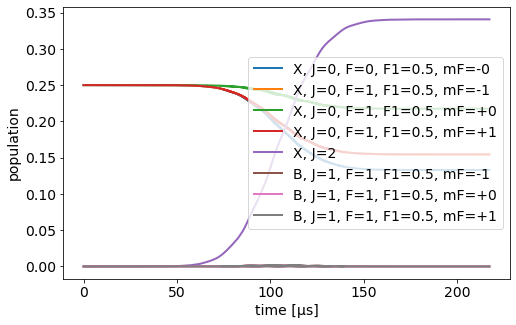

In [28]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QNcompact[idx].find_largest_component()
        if s.F is None:
            label = f'{s.electronic_state}, J={s.J}'
        else:
            label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

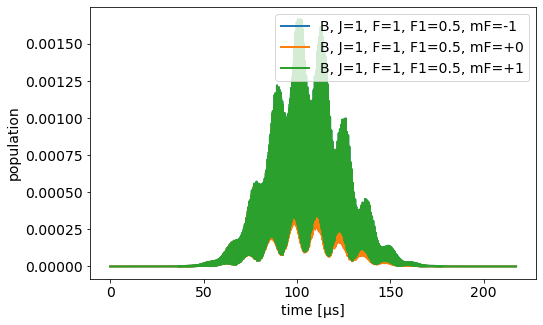

In [29]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx >= H_symbolic.shape[0] - len(excited_states):
        s = QNcompact[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Scan detuning

In [30]:
odepars.Ωl = 0.4*Γ
odepars.ωp = 1*Γ
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.40, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03)


In [31]:
# ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True, 
#                                          slice_compact = slice_compact)
ρ_ini = centrex.utils.generate_population_states([0,1,2,3], H_symbolic.shape[0])
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [32]:
δls = np.linspace(-5,5,101)*Γ

In [33]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, 'δl', δls)

In [34]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_state_integral_calculation([6,7,8])

In [35]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [36]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [37]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-8, reltol = 1e-5)
sim.elapsedTime
""")

25.4113317

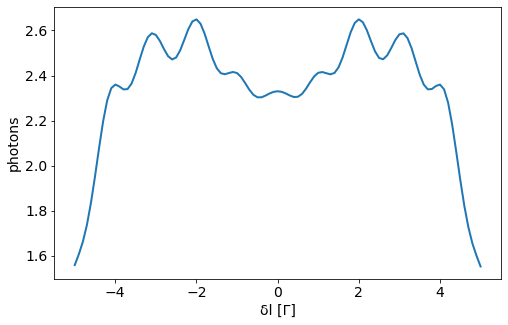

In [38]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)*Γ, lw = 2)

ax.set_xlabel('δl [Γ]')
ax.set_ylabel('photons')

set_fontsize(ax, 14)

## Scan detuning and laser power before rotational cooling 

In [39]:
ρ_ini = centrex.utils.generate_thermal_J([0,1,2,3], len(excited_states), T, normalized = True, 
                                         slice_compact = None)
ρ_ini = ρ_ini[:H_symbolic.shape[0],:H_symbolic.shape[0]]
ρ_ini[-len(excited_states):,-len(excited_states):] = 0
ρ_ini[4,4] = 0
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [40]:
Ωls = centrex.utils.calculate_rabi_from_power_gaussian_beam(np.linspace(0,60e-3,51), 
                                                            np.abs(couplings[0]['main coupling'].real),
                                                            σx = 1e-2/2, σy = 1e-2/2)
δls = np.linspace(-3,3,101)*Γ

In [41]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_ND(odepars, ['Ωl', 'δl'], [Ωls, δls])

In [42]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_state_integral_calculation([6,7,8])

In [43]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [44]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [45]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true)
sim.elapsedTime
""")

72.4875119

In [46]:
params = np.asarray(Main.params)
results = np.array(Main.eval("sim.u"))*Γ
lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(params[:,0], 
                                                               np.abs(couplings[0]['main coupling'].real),
                                                                σx = 1e-2/2, σy = 1e-2/2)

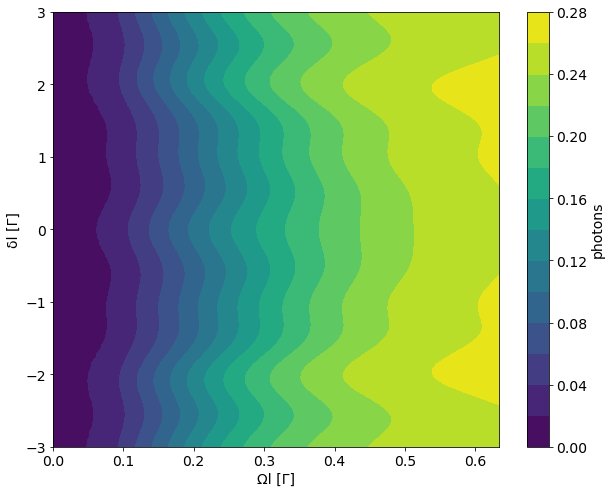

In [47]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]/Γ, params[:,1]/Γ, results, levels = 15)

cbar = fig.colorbar(tcf)
# ax.scatter(lpower*1e3, params[:,1]/Γ, color = 'k')

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'δl [Γ]')
cbar.ax.set_ylabel('photons')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

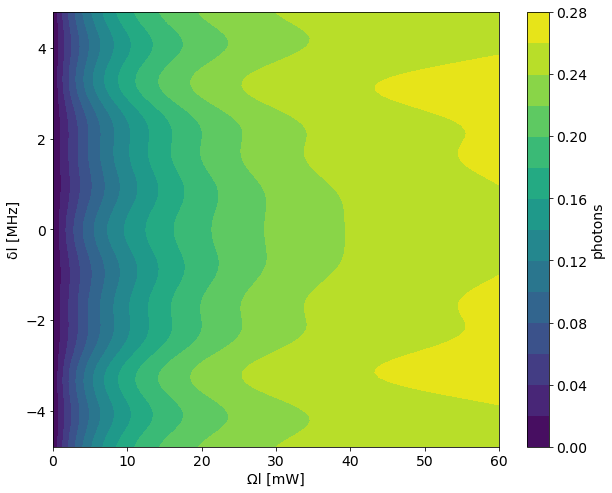

In [48]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(lpower*1e3, params[:,1]*1.6/Γ, results, levels = 15)

cbar = fig.colorbar(tcf)
# ax.scatter(lpower*1e3, params[:,1]/Γ, color = 'k')

ax.set_xlabel('Ωl [mW]')
ax.set_ylabel(r'δl [MHz]')
cbar.ax.set_ylabel('photons')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Setup with values from RC simulation, with initial thermal population

In [80]:
data_dir = Path('.').absolute().parent.parent.parent / 'with microwaves'
fname = 'laser_mu1mu2_rc_pol_switching_on_apertures_phasemod_2020_10_28_2x_beamheight.npy'
results_array = np.load(data_dir / fname)

In [81]:
# laser power for RC
m = results_array[:,0] == 10000000
# μ1 power for RC
m = m & (results_array[:,1] == 20000000)
# μ2 power for RC
m = m & (results_array[:,2] == 20000000)

δls, vzs, vys, y0s = results_array[m][:,[3,4,5,6]].T

38.39" from cell opening to DET laser.
Start simulation 1" from the start of the laser, i.e. the molecules travel 37.39".

In [82]:
# new y0 positions 1" in front of DET laser
y0s_start = (37.39*25.4*1e-3)/vzs * vys + y0s

In [83]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")

In [84]:
ρ_ini = centrex.utils.generate_thermal_J([0,1,2,3], len(excited_states), T, normalized = True, 
                                         slice_compact = None)
ρ_ini = ρ_ini[:H_symbolic.shape[0],:H_symbolic.shape[0]]
ρ_ini[4,4] = 0
ρ_ini[-len(excited_states):,-len(excited_states):] = 0
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [85]:
Main.eval(f"""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [86]:
# terminate integration 1" behind the detection laser
Main.eval("""
@everywhere function affect!(integrator)
    terminate!(integrator)
end
@everywhere condition(u,t,integrator) = integrator.p[7]*t > 50.8e-3
cb = DiscreteCallback(condition, affect!)
""");

In [87]:
odepars.Ωl = 0.5*Γ
odepars.ωl = 2*np.pi*1e6
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.50, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03)


In [88]:
Main.eval(f"""
@everywhere function prob_func_prerc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                    params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, {odepars.β}, {odepars.ωphase}])
end
""")

In [89]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob_prerc = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);
""");

In [90]:
Main.eval("""
@time sim = solve(ens_prob_prerc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
sim.elapsedTime
""")

39.0804657

In [91]:
results = np.array(Main.eval("sim.u"))*Γ

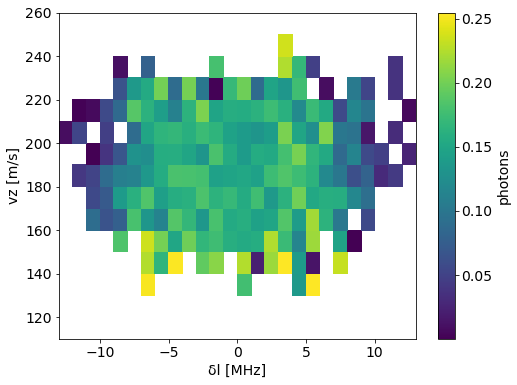

In [92]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Setup with values from RC simulation, with post-RC population

In [94]:
ρrc = []
for pop in results_array[m][:,-67:][:,:4]:
    _ρ = np.zeros(ρ_ini.shape, dtype = ρ_ini.dtype)
    np.fill_diagonal(_ρ[:4,:4], pop)
    ρrc.append(_ρ)

38.39" from cell opening to DET laser.
Start simulation 1" from the start of the laser, i.e. the molecules travel 37.39".

In [95]:
# new y0 positions 1" in front of DET laser
y0s_start = (37.39*25.4*1e-3)/vzs * vys + y0s

In [96]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")
Main.ρrc = ρrc
Main.eval("@everywhere ρrc = $ρrc")

In [97]:
Main.eval(f"""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [98]:
odepars.Ωl = 0.5*Γ
odepars.ωl = 2*np.pi*1e6
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.50, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03)


In [102]:
Main.eval(f"""
@everywhere function prob_func_postrc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                    params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, {odepars.β}, {odepars.ωphase}], u0 = ρrc[i])
end
""")

In [103]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob_postrc = EnsembleProblem(prob, prob_func = prob_func_postrc, output_func = output_func);
""");

In [104]:
Main.eval("""
@time sim = solve(ens_prob_postrc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
sim.elapsedTime
""")

55.9684211

In [105]:
results_RC = np.array(Main.eval("sim.u"))*Γ

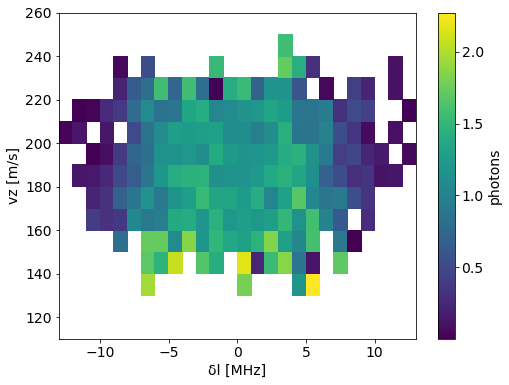

In [106]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results_RC
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

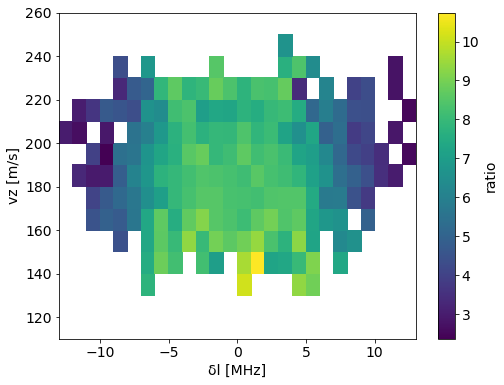

In [107]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results_RC/results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('ratio')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [108]:
# apparent ratio
ratio_measured = results_RC.mean()/results.mean()
ratio_real = results_array[m][:,-67:][:,:4].sum(axis = 1).mean()/ρ_ini.trace().real
print(f"ratio measured : {ratio_measured:.2f}")
print(f"ratio real : {ratio_real:.2f}") 
print(f"measured / real : {ratio_measured/ratio_real:.2f}")

ratio measured : 7.54
ratio real : 7.29
measured / real : 1.03


## Scan Rabi rate

In [146]:
Ωls = centrex.utils.calculate_rabi_from_power_gaussian_beam(np.linspace(0,200e-3,51), 
                                                            np.abs(couplings[0]['main coupling'].real),
                                                            σx = 1e-2/2, σy = 1e-2/2)

In [147]:
results_rc = []
results = []
for Ωl in tqdm(Ωls):    
    Main.eval(f"""
    @everywhere function prob_func_postrc(prob,i,repeat)
        remake(prob,p=[{Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                        params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, 
                        {odepars.β}, {odepars.ωphase}], u0 = ρrc[i])
    end
    """);
    
    Main.eval(f"""
    @everywhere function prob_func_prerc(prob,i,repeat)
        remake(prob,p=[{Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                        params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, 
                        {odepars.β}, {odepars.ωphase}])
    end
    """);
    
    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob_postrc = EnsembleProblem(prob, prob_func = prob_func_postrc, output_func = output_func);
    ens_prob_prerc  = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);
    """);
    Main.eval("""
    @time sim = solve(ens_prob_prerc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
    """);
    pre_RC = np.array(Main.eval("sim.u"))*Γ
    Main.eval("""
    @time sim = solve(ens_prob_postrc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
    """);
    post_RC = np.array(Main.eval("sim.u"))*Γ
    results_rc.append(post_RC.mean())
    results.append(pre_RC.mean())

100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [1:36:27<00:00, 113.47s/it]


<ipython-input-148-22551e812b19>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(Ωls/Γ, results_rc/results, '.', ms = 12)


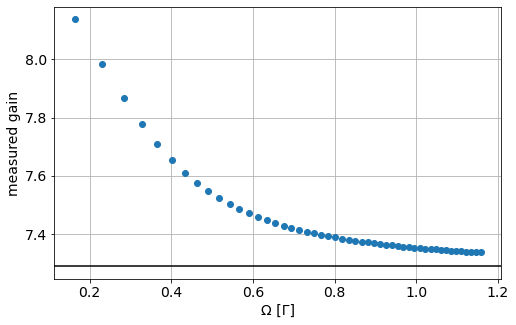

In [148]:
results_rc = np.asarray(results_rc)
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Ωls/Γ, results_rc/results, '.', ms = 12)
ax.axhline(ratio_real, color = 'k')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel("measured gain")

ax.grid(True)

set_fontsize(ax, 14)

In [149]:
lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(Ωls, 
                                                               np.abs(couplings[0]['main coupling'].real),
                                                               σx = 1e-2/2, σy = 1e-2/2)

<ipython-input-150-482c273b38c3>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(lpower*1e3, results_rc/results, '.', ms = 12, label = 'detected')


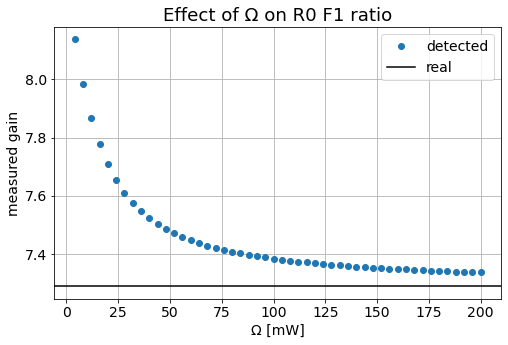

In [150]:
results_rc = np.asarray(results_rc)
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(lpower*1e3, results_rc/results, '.', ms = 12, label = 'detected')
ax.axhline(ratio_real, color = 'k', label = 'real')

ax.set_xlabel('Ω [mW]')
ax.set_ylabel("measured gain")
ax.set_title('Effect of Ω on R0 F1 ratio')
ax.legend(fontsize = 14)

ax.grid(True)

set_fontsize(ax, 14)

In [154]:
results_R0F1 = (results_rc/results).copy()
results_R0F2 = np.array([       
    np.nan, 3.57408141, 3.56743174, 3.56205412, 3.55775713,
    3.55435445, 3.55165286, 3.54949222, 3.5477592 , 3.54634607,
    3.5452005 , 3.54426088, 3.54347507, 3.54281855, 3.54227129,
    3.54182731, 3.54144137, 3.54111675, 3.54085523, 3.54062428,
    3.54044181, 3.54027468, 3.54014473, 3.54004013, 3.53994491,
    3.53986817, 3.53980916, 3.53977581, 3.53971963, 3.53969441,
    3.53968298, 3.53965775, 3.53966127, 3.53966424, 3.53966896,
    3.53968284, 3.53969525, 3.53971252, 3.53973662, 3.53976228,
    3.53978344, 3.53982442, 3.53985821, 3.53988701, 3.5399261 ,
    3.53996026, 3.53998956, 3.54003808, 3.54007137, 3.54011685,
    3.54014893])


<ipython-input-154-d6b5c0d9a756>:1: RuntimeWarning: invalid value encountered in true_divide
  results_R0F1 = (results_rc/results).copy()


In [155]:
gain_F0 = results_array[m][:,-67:][:,0].mean()/ρ_ini[0,0].real

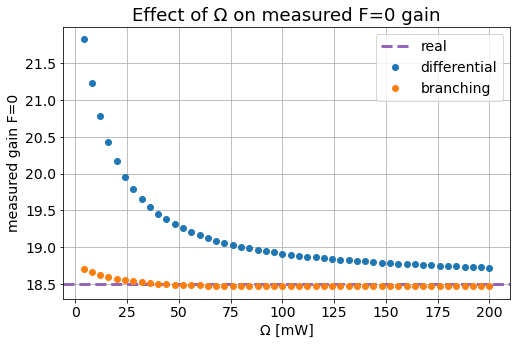

In [156]:
fig, ax = plt.subplots(figsize = (8,5))

ax.axhline(gain_F0, color = 'C4', lw = 3, label = 'real', ls = '--')
ax.plot(lpower*1e3, 4*results_R0F1 - 3*results_R0F2, '.', ms = 12, label = 'differential')
ax.plot(lpower*1e3, 3*(0.337/0.147)*(results_R0F2 - 1) + 1, '.', ms = 12, label = 'branching')

ax.set_title('Effect of Ω on measured F=0 gain')
ax.set_xlabel('Ω [mW]')
ax.set_ylabel("measured gain F=0")

ax.legend(fontsize = 14)
ax.grid(True)

set_fontsize(ax, 14)

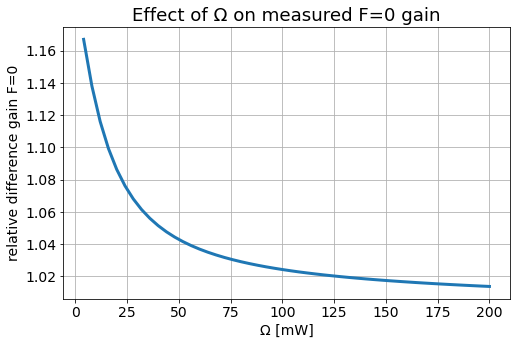

In [160]:
gainF0_diff = 4*results_R0F1 - 3*results_R0F2
gainF0_br = 3*(0.337/0.147)*(results_R0F2 - 1) + 1

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(lpower*1e3, gainF0_diff/gainF0_br, lw = 3)

ax.set_title('Effect of Ω on measured F=0 gain')
ax.set_xlabel('Ω [mW]')
ax.set_ylabel("relative difference gain F=0")
ax.grid(True)

set_fontsize(ax, 14)